In [8]:
import os, time, random
import json
import numpy as np
import h5py
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt


In [18]:

infile ='/pscratch/sd/b/bbbam/IMG_aToTauTau_m1p2T018_combined_normalized_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_train_normalized.h5'
unphy_bins = np.arange(-1.2,1.3,0.4)

chunk_size =32
batch_size = 320

data = h5py.File(f'{infile}', 'r')
# num_images = data["all_jet"].shape[0]

num_images = 1000

# if not os.path.exists(outdir):
#     os.makedirs(outdir)

prefix = infile.split('/')[-1].split('.')[0]
outfile = f'{prefix}_unphysica_negative_mass.h5'

with h5py.File(f'{outfile}', 'w') as proper_data:
    dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'apt']
    datasets = {
    name: proper_data.create_dataset(
        name,
        shape= (0,13, 125, 125) if 'all_jet' in name else (0,1),
        maxshape=(None, 13, 125, 125) if 'all_jet' in name else (None, 1),
        dtype='float32',  # Specify an appropriate data type
        compression='lzf',
        chunks=(chunk_size, 13, 125, 125) if 'all_jet' in name else (chunk_size, 1),
    ) for name in dataset_names
        }
    orig_num_am = 0
    start_idx_, end_idx_, start_idx = 0, 0, 0
    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        am_batch = data["am"][start_idx:end_idx, :]
        ieta_batch = data["ieta"][start_idx:end_idx, :]
        iphi_batch = data["iphi"][start_idx:end_idx, :]
        apt_batch = data["apt"][start_idx:end_idx, :]



        lowest_mass_mask = am_batch < 1.6
        images_batch = images_batch[lowest_mass_mask.flatten()]
        am_batch = am_batch[lowest_mass_mask]
        ieta_batch = ieta_batch[lowest_mass_mask]
        iphi_batch = iphi_batch[lowest_mass_mask]
        apt_batch = apt_batch[lowest_mass_mask]
        orig_num_am = orig_num_am + len(am_batch)
        start_idx_ = min(start_idx, end_idx_)
        end_idx_   = min(start_idx_ + images_batch.shape[0], num_images)

        if len(images_batch) <1 : continue

        new_am_batch = []
        new_images_batch =[]
        new_ieta_batch = []
        new_iphi_batch = []
        new_apt_batch = []

        for i in range(len(images_batch)):
            # Generate a random mass in each bin
            temp_am_batch = np.array([[np.random.uniform(low, high)] for low, high in zip(unphy_bins[:-1], unphy_bins[1:])])
            new_am_batch.append(temp_am_batch)
            # print("new_images_batch", new_images_batch.shape)
            # dublicate image for each unphysical mass bins
            temp_images_batch = np.repeat(images_batch[i][np.newaxis, ...], len(unphy_bins)-1, axis=0)
            new_images_batch.append(temp_images_batch)
            temp_ieta_batch = np.repeat(ieta_batch[i][np.newaxis, ...], len(unphy_bins)-1, axis=0)
            new_ieta_batch.append(temp_ieta_batch)
            temp_iphi_batch = np.repeat(iphi_batch[i][np.newaxis, ...], len(unphy_bins)-1, axis=0)
            new_iphi_batch.append(temp_iphi_batch)
            temp_apt_batch = np.repeat(apt_batch[i][np.newaxis, ...], len(unphy_bins)-1, axis=0)
            new_apt_batch.append(temp_apt_batch)

        new_am_batch = np.concatenate(new_am_batch, axis=0)
        new_images_batch = np.concatenate(new_images_batch, axis=0)
        new_ieta_batch = np.concatenate(new_ieta_batch, axis=0)
        new_iphi_batch = np.concatenate(new_iphi_batch, axis=0)
        new_apt_batch = np.concatenate(new_apt_batch, axis=0)

        np.random.shuffle(new_am_batch)
        np.random.shuffle(new_images_batch)
        np.random.shuffle(new_ieta_batch)
        np.random.shuffle(new_iphi_batch)
        np.random.shuffle(new_apt_batch)
        # plt.hist(np.concatenate(new_am_batch), bins=np.arange(-1.2,1.3,0.4))
        # plt.show()
        end_idx = start_idx + len(new_images_batch)
        # print("end_idx", end_idx)
        # print("len(am_batch)", am_batch.shape)
        for name, dataset in datasets.items():
            dataset.resize((end_idx,13, 125, 125) if 'all_jet' in name else (end_idx,1))

        proper_data['all_jet'][start_idx:end_idx,:,:,:] = new_images_batch
        proper_data['am'][start_idx:end_idx] = new_am_batch
        proper_data['ieta'][start_idx:end_idx] = new_ieta_batch.reshape(-1, 1)
        proper_data['iphi'][start_idx:end_idx] = new_iphi_batch.reshape(-1, 1)
        proper_data['apt'][start_idx:end_idx] = new_apt_batch.reshape(-1, 1)

        start_idx = end_idx

        # print("_____________________________________________________________")
    print("original number of am  --> ", orig_num_am)
data.close()

100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

original number of am.  22


966


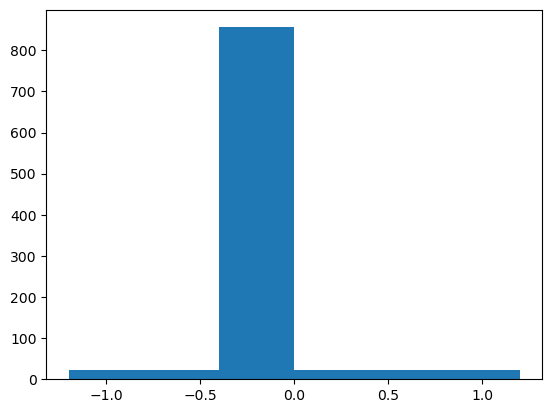

In [19]:
infile_new ='IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_train_normalized_unphysica_negative_mass.h5'
data = h5py.File(f'{infile_new}', 'r')
num_images = data["all_jet"].shape[0]
print(num_images)
import matplotlib.pyplot as plt
mass = data["am"][:]
plt.hist(mass, bins=np.arange(-1.2,1.3,0.4))
plt.show()